## Manual

In [30]:
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic regression data.
# n_informative=20 means that only 20 features actually affect the target.
n_samples = 100
n_features = 1000
n_informative = 20

print("Generating synthetic regression dataset...")
X_data, y_data, true_coef = make_regression(n_samples=n_samples, 
                                            n_features=n_features, 
                                            n_informative=n_informative, 
                                            noise=3,
                                            coef=True, 
                                            random_state=42)

print("Dataset shapes: ")
print("X_data:", X_data.shape)
print("y_data:", y_data.shape)

# Display a summary of the true coefficients.
true_coef_nonzero = np.where(true_coef != 0)[0]
print("Indices of informative (non-zero) true coefficients:", true_coef_nonzero)
print("Number of informative features:", len(true_coef_nonzero))


Generating synthetic regression dataset...
Dataset shapes: 
X_data: (100, 1000)
y_data: (100,)
Indices of informative (non-zero) true coefficients: [119 150 180 205 287 299 424 438 574 700 710 731 778 782 793 800 856 882
 898 983]
Number of informative features: 20


In [31]:
# %% [code]
# Standardize X: subtract mean and divide by standard deviation (feature-wise)
X_mean = np.mean(X_data, axis=0)
X_std = np.std(X_data, axis=0)
X_scaled = (X_data - X_mean) / X_std

# Center y by subtracting its mean (this is common in linear regression)
y_mean = np.mean(y_data)
y_centered = y_data - y_mean

print("Data standardization complete.")


Data standardization complete.


In [32]:
# %% [code]
def soft_thresholding(rho, lam):
    """
    Soft-thresholding operator.
    For a given value rho and threshold lam, returns:
       sign(rho) * max(|rho| - lam, 0)
    """
    return np.sign(rho) * max(abs(rho) - lam, 0.0)

# Quick demo:
print("Soft-thresholding examples:")
for val in [-0.5, -0.2, 0, 0.2, 0.5]:
    print(f"S({val}, 0.3) = {soft_thresholding(val, 0.3)}")


Soft-thresholding examples:
S(-0.5, 0.3) = -0.2
S(-0.2, 0.3) = -0.0
S(0, 0.3) = 0.0
S(0.2, 0.3) = 0.0
S(0.5, 0.3) = 0.2


In [33]:
# %% [code]
def lasso_coordinate_descent(X, y, lam, max_iter=5000, tol=1e-4):
    """
    Solves the LASSO regression problem using coordinate descent.
    
    Arguments:
      X       : The standardized design matrix (n_samples x n_features)
      y       : The centered target vector (n_samples,)
      lam     : Regularization parameter (lambda)
      max_iter: Maximum number of iterations (complete passes over all features)
      tol     : Convergence tolerance (change in beta)
      
    Returns:
      beta    : The estimated coefficient vector (n_features,)
    """
    n, p = X.shape
    beta = np.zeros(p)  # Initialize coefficients to zero.
    beta_history = []
    
    for iteration in range(max_iter):
        beta_old = beta.copy()
        for j in range(p):
            # Compute the "partial residual" for feature j:
            # We want to compute:
            #   r_j = (1/n) * sum_i [x_ij * (y_i - sum_{k != j} x_ik * beta_k)]
            # A neat trick: Compute the full prediction X @ beta, then add back the contribution
            # of feature j (which was subtracted out) so that:
            #   residual = y - (X @ beta) + beta_j * X[:, j]
            residual = y - (X @ beta) + beta[j] * X[:, j]
            # Compute the correlation of feature j with the residual.
            rho = np.dot(X[:, j], residual) / n
            
            # Compute normalization factor (squared norm of feature j)
            norm_j = np.sum(X[:, j] ** 2) / n
            
            # Update beta[j] using the soft-thresholding operator.
            beta[j] = soft_thresholding(rho, lam) / norm_j
        
        beta_history.append(beta.copy())

        # Check for convergence (if the change in beta is small, break)
        if np.linalg.norm(beta - beta_old, ord=2) < tol:
            print("Converged at iteration", iteration)
            break
    return beta, beta_history

# Test the coordinate descent function with a chosen lambda.
lam = 0.1  # Regularization strength (you can experiment with different values)
beta_manual, beta_history = lasso_coordinate_descent(X_scaled, y_centered, lam, max_iter=5000, tol=1e-4)
print("Manual LASSO coefficients (first 30):")
print(beta_manual[:30])


Converged at iteration 3849
Manual LASSO coefficients (first 30):
[-0.        -0.        -0.7756657  0.        -0.        -0.
  0.        -0.        -0.         0.         0.        -0.
  0.         0.        -0.        -0.        -0.        -0.
 -0.         0.        -1.238705  -0.         0.        -0.
 -0.        -0.         0.         0.        -0.        -0.       ]


In [34]:
beta_history = np.array(beta_history)

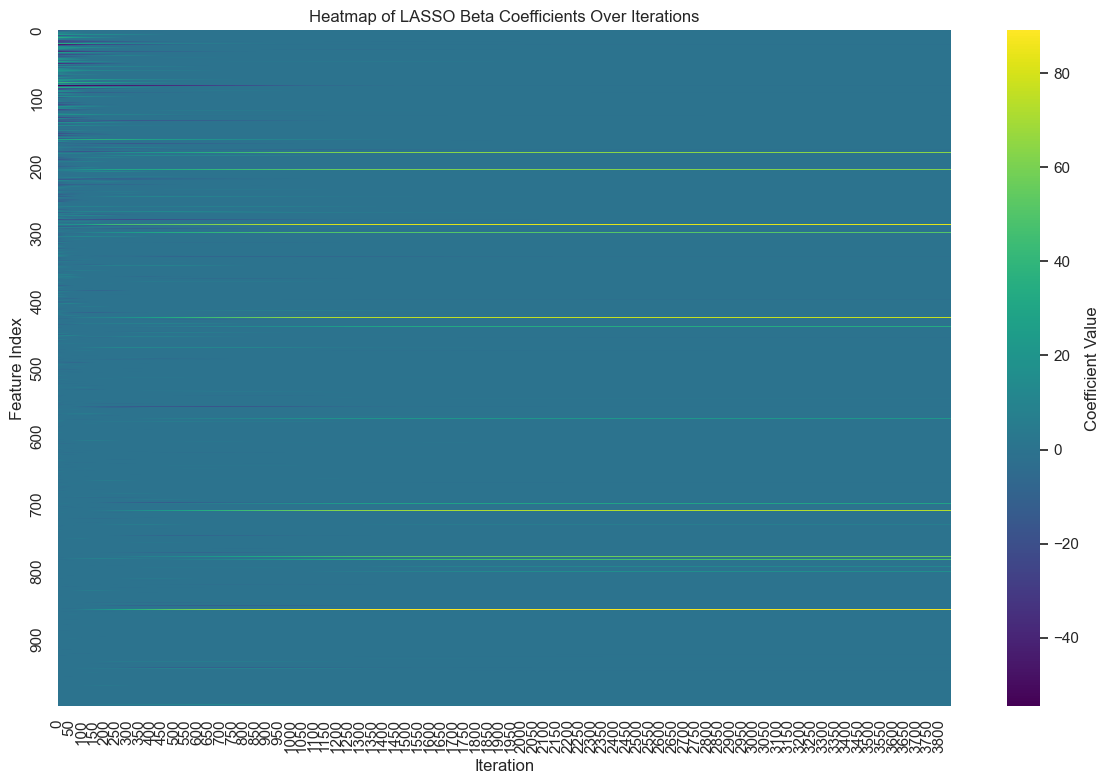

In [35]:
beta_matrix = beta_history.T

plt.figure(figsize=(12, 8))
sns.heatmap(beta_matrix, cmap='viridis', cbar_kws={'label': 'Coefficient Value'},
            xticklabels=50,  # Show tick every 50 iterations for clarity
            yticklabels=100)  # Show tick every 100 features
plt.xlabel("Iteration")
plt.ylabel("Feature Index")
plt.title("Heatmap of LASSO Beta Coefficients Over Iterations")
plt.tight_layout()
plt.show()

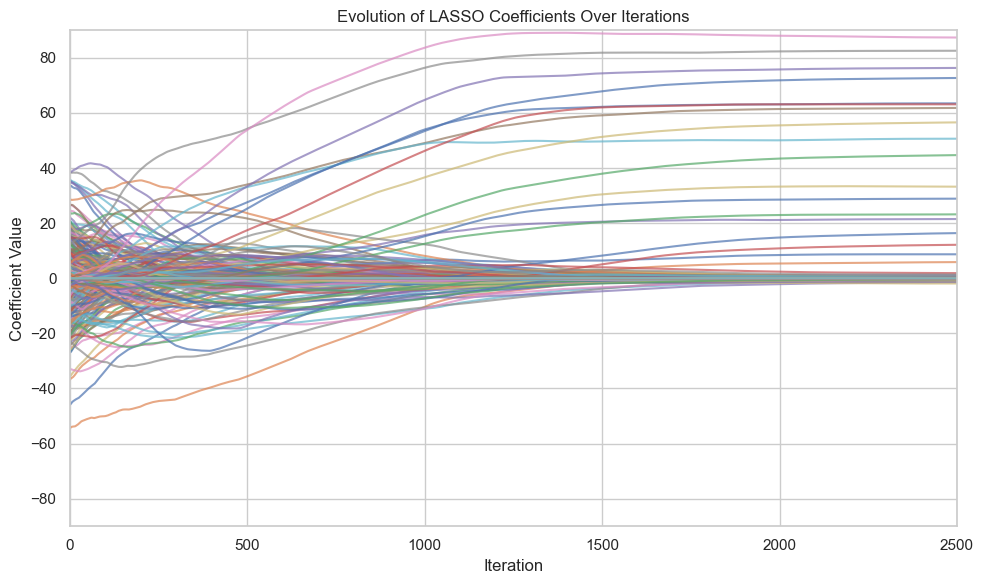

In [36]:
plt.figure(figsize=(10, 6))
for i, j in enumerate(np.arange(1000)):
    plt.plot(beta_history[:, i], label=f'Feature {j}', alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Coefficient Value")
plt.title("Evolution of LASSO Coefficients Over Iterations")
plt.xlim(0, 2500)
plt.ylim(-90, 90)
plt.tight_layout()
plt.show()

In [14]:
np.where(beta_manual != 0)[0]

array([ 20,  28,  45,  76,  81, 119, 129, 150, 157, 176, 180, 188, 205,
       212, 245, 269, 287, 291, 299, 334, 335, 372, 398, 414, 424, 438,
       449, 469, 487, 514, 544, 556, 574, 588, 610, 698, 700, 710, 718,
       731, 778, 782, 790, 793, 800, 837, 856, 882, 898, 925, 926, 929,
       933, 934, 942, 943, 983, 997])

In [15]:
len(np.where(beta_manual != 0)[0])

58

In [16]:
# %% [code]
# Find indices of coefficients that are non-zero in our manual LASSO result.
selected_indices = np.where(beta_manual != 0)[0]
print("Number of features selected (non-zero coefficients):", len(selected_indices))
print("Indices of selected features:", selected_indices)

# Compare with ground truth informative features.
true_informative_indices = np.where(true_coef != 0)[0]
print("Ground truth informative feature indices:", true_informative_indices)

# Compute the intersection
common_features = set(selected_indices).intersection(set(true_informative_indices))
print("Features recovered (intersection):", sorted(common_features))
print("Fraction of ground truth features recovered: {}/{} = {:.2f}".format(
    len(common_features), len(true_informative_indices),
    len(common_features) / len(true_informative_indices)))


Number of features selected (non-zero coefficients): 58
Indices of selected features: [ 20  28  45  76  81 119 129 150 157 176 180 188 205 212 245 269 287 291
 299 334 335 372 398 414 424 438 449 469 487 514 544 556 574 588 610 698
 700 710 718 731 778 782 790 793 800 837 856 882 898 925 926 929 933 934
 942 943 983 997]
Ground truth informative feature indices: [119 150 180 205 287 299 424 438 574 700 710 731 778 782 793 800 856 882
 898 983]
Features recovered (intersection): [119, 150, 180, 205, 287, 299, 424, 438, 574, 700, 710, 731, 778, 782, 793, 800, 856, 882, 898, 983]
Fraction of ground truth features recovered: 20/20 = 1.00
